In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from random import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.base import clone

import os
import matplotlib.cm as cmx
import matplotlib.patches as patches
from matplotlib.colors import LogNorm


# vizualization functions:


In [0]:

def visualize_3d_gmm(points, w, mu, stdev, export=False):
    '''
    plots points and their corresponding gmm model in 3D
    Input: 
        points: N X 3, sampled points
        w: n_gaussians, gmm weights
        mu: 3 X n_gaussians, gmm means
        stdev: 3 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''

    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    fig = plt.figure(figsize=(8, 8))
    axes = fig.add_subplot(111, projection='3d')
    #axes.set_xlim([-1, 1])
    #axes.set_ylim([-1, 1])
    #axes.set_zlim([-1, 1])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        axes.scatter(points[idx, 0], points[idx, 1], points[idx, 2], alpha=0.3, c=colors[i])
        plot_sphere(w=w[i], c=mu[:, i], r=stdev[:, i], ax=axes)

    plt.title('3D GMM')
    axes.set_xlabel('X')
    axes.set_ylabel('Y')
    axes.set_zlabel('Z')
    axes.view_init(35.246, 45)
    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/3D_GMM_demonstration.png', dpi=100, format='png')
    plt.show()

def plot_sphere(w=0, c=[0,0,0], r=[1, 1, 1], subdev=10, ax=None, sigma_multiplier=3):
    '''
        plot a sphere surface
        Input: 
            c: 3 elements list, sphere center
            r: 3 element list, sphere original scale in each axis ( allowing to draw elipsoids)
            subdiv: scalar, number of subdivisions (subdivision^2 points sampled on the surface)
            ax: optional pyplot axis object to plot the sphere in.
            sigma_multiplier: sphere additional scale (choosing an std value when plotting gaussians)
        Output:
            ax: pyplot axis object
    '''

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:complex(0,subdev), 0.0:2.0 * pi:complex(0,subdev)]
    x = sigma_multiplier*r[0] * sin(phi) * cos(theta) + c[0]
    y = sigma_multiplier*r[1] * sin(phi) * sin(theta) + c[1]
    z = sigma_multiplier*r[2] * cos(phi) + c[2]
    cmap = cmx.ScalarMappable()
    cmap.set_cmap('jet')
    c = cmap.to_rgba(w)

    ax.plot_surface(x, y, z, color=c, alpha=0.2, linewidth=1)

    return ax



def visualize_2d_gmm(points, w, mu, stdev, export=False):
    '''
    plots points and their corresponding gmm model in 2D
    Input: 
        points: N X 2, sampled points
        w: n_gaussians, gmm weights
        mu: 2 X n_gaussians, gmm means
        stdev: 2 X n_gaussians, gmm standard deviation (assuming diagonal covariance matrix)
    Output:
        None
    '''
    n_gaussians = mu.shape[1]
    N = int(np.round(points.shape[0] / n_gaussians))
    # Visualize data
    plt.figure(figsize=(8, 8))
    axes = plt.gca()
    #axes.set_xlim([-1, 1])
    #axes.set_ylim([-1, 1])
    plt.set_cmap('Set1')
    colors = cmx.Set1(np.linspace(0, 1, n_gaussians))
    for i in range(n_gaussians):
        idx = range(i * N, (i + 1) * N)
        plt.scatter(points[idx, 0], points[idx, 1], alpha=0.3, c=colors[i])
        for j in range(8):
            axes.add_patch(
                patches.Ellipse(mu[:, i], width=(j+1) * stdev[0, i], height=(j+1) *  stdev[1, i], fill=False, color=[0.0, 0.0, 1.0, 1.0/(0.5*j+1)]))
        plt.title('GMM')
    plt.xlabel('X')
    plt.ylabel('Y')

    if export:
        if not os.path.exists('images/'): os.mkdir('images/')
        plt.savefig('images/2D_GMM_demonstration.png', dpi=100, format='png')

    plt.show()
    

def visualize_gmm(gmm,X):
    if X.shape[1] == 3:
        visualize_3d_gmm(X, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)
    elif X.shape[1] == 2 and gmm.covariance_type == 'diag':
        visualize_2d_gmm(X, gmm.weights_, gmm.means_.T, np.sqrt(gmm.covariances_).T)    
    elif X.shape[1] == 2:
        plt.figure()
        contour_axes = np.linspace(np.min(X), np.max(X))
        mesh_x1,mesh_x2 = np.meshgrid(contour_axes, contour_axes)
        mesh = np.array([mesh_x1.ravel(), mesh_x2.ravel()]).T
        Z = -gmm.score_samples(mesh)
        Z = Z.reshape(mesh_x1.shape)
        plt.contour(mesh_x1, mesh_x2, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
        plt.scatter(X[:, 0], X[:, 1], .8)
        plt.scatter(gmm.means_[:,0],gmm.means_[:,1])


def make_chart (chart_data, y_pred, newplot=True):
    if newplot:
      fig = plt.figure()
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)
    

def pca_visualization(X,y,title='', newplot=True,legend=True):
    if X.shape[1] == 3:
        make_chart(X, y,newplot=newplot)
    elif X.shape[1] == 2:
        if newplot:
          plt.figure()
        scatter  = plt.scatter(X[:,0], X[:,1], c=y)
        classes = list(set(y))
        if legend:
          plt.legend(handles=scatter.legend_elements()[0], labels=classes)
        plt.title(title)

#DataGenerator:

In [0]:
class DataGenerator:
    def __init__(self):
        pass
        
    """
    Parameters
    ----------
    n_samples : int or array-like, optional (default=100)
        If int, it is the total number of points equally divided among
        clusters.
        If array-like, each element of the sequence indicates
        the number of samples per cluster.
    n_features : int, optional (default=3)
        The number of features for each sample.
    centers : int or array of shape [n_centers, n_features], optional
        (default=None)
        The number of centers to generate, or the fixed center locations.
        If n_samples is an int and centers is None, 3 centers are generated.
        If n_samples is array-like, centers must be
        either None or an array of length equal to the length of n_samples.
    cluster_std : float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.
    random_state : int, or None (default)
        Determines random number generation for dataset creation

    """        
    def generate(self,n_samples=100,n_features=3,cluster_std=0.5, centers=None,random_state=None):
        return make_blobs(
            random_state=random_state,
            n_samples=n_samples, 
            centers=centers, 
            n_features=n_features,
            cluster_std=cluster_std)    

    def add_noise_channels(self,X,noise_channels_to_add):
        noise = np.random.uniform(low=np.min(X), high=np.max(X),size=(len(X),noise_channels_to_add))
        X= np.hstack((X,noise))
        return X

# ClusterFinder

In [0]:
class ClusterFinder:

    def __init__(self, pipe,num_iter=5):
        self.num_iter = num_iter
        self.pipe = pipe
        self.best_score=0
        self.k_val=0
        
    """
    https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    """
    #BIC
    def optimal_k_bic(self,X,num_iterations=20):

        K = range(1,10)
        bic = np.zeros((len(K),num_iterations))
        for k in K:
            for i in range(num_iterations):
                self.pipe['model'].n_components=k
                X_pca = self.transform(X)
                self.pipe['model'].fit(X_pca)
                bic[k-1,i] = self.pipe['model'].bic(X_pca)
        
        bic=np.mean(bic,axis=1)
        plt.figure()
        plt.plot(K,bic) 
        
        # find elbow: first +1 because k values are 1..10, not 0..9. second +1 is because we round up
        self.k_val = np.argmax(np.roll(bic,1)-bic)+1+1   

        return self.k_val
    
    
    def optimal_k_silhouette(self,X,num_iterations=20):
    
        """Since we already know that the fitting procedure is not deterministic, we run the fit several times for each number of clusters"""
        """ silhouette seems to be very bad in presence of noise"""
        K = range(2,10)
        silhouette = np.zeros((len(K),num_iterations))
        for k in K:
            for i in range(num_iterations):
                self.pipe['model'].n_components=k
                X_pca = self.transform(X)
                gmm = self.pipe['model']
                gmm.fit(X_pca)        
                silhouette[k-2,i] = silhouette_score(X_pca, gmm.predict(X_pca))
        
        """best five values, then average"""        
        silhouette=np.sort(silhouette,axis=1)[:,-5:]
        silhouette=np.mean(silhouette,axis=1)
        plt.figure()
        plt.plot(K,silhouette)
    
        self.k_val = np.argmax(silhouette)+2 #because K starts from 2.
        return self.k_val 

    def fit(self, X):
        self.pipe.fit(X,y)

    def transform(self, X):
        self.pipe['scalar'].fit(X)
        return self.pipe['pca'].fit_transform(self.pipe['scalar'].transform(X))
    
    def predict(self, X):
        return self.pipe.predict(X)
        
    def bic(self,X):
        self.pipe['model'].bic(self.transform(X))

# Exploring 

## Generating data and noise analysis

Generating 3 blobs and adding 2 channels of noise

shape X pre noise: (500, 3)
shape X after noise: (500, 5)


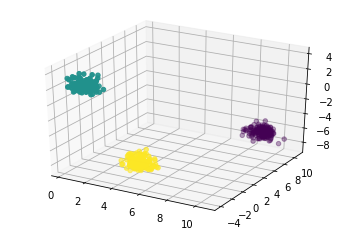

In [0]:
datagen = DataGenerator()
X, y = datagen.generate(n_samples=500,centers=3,cluster_std=0.5)
make_chart(X,y)
print("shape X pre noise:",X.shape)
X= datagen.add_noise_channels(X,2)
print("shape X after noise:",X.shape)


Instantiating the ClusterFinder object

In [0]:
pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model',GaussianMixture(n_components=5,covariance_type='full'))
])

model = ClusterFinder(pipe)

This is how the data looks after PCA:

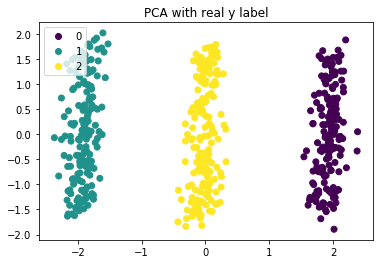

In [0]:
X_pca = model.transform(X)
pca_visualization(X_pca,y,'PCA with real y label')

Let's run several combinations of cluster numbers and noise channels to see how it behaves after PCA stage:

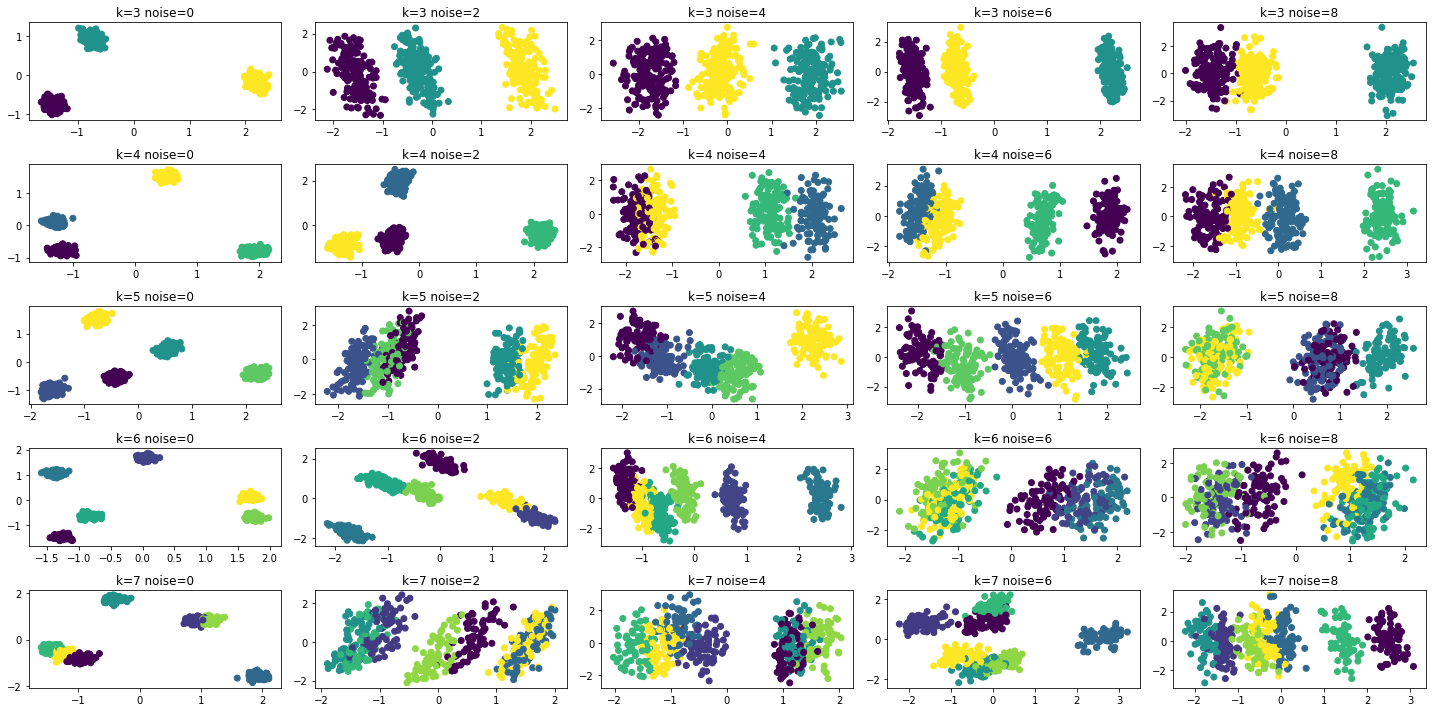

In [0]:
clusters =range (3,8)
noise_channels = range(0,10,2)
i=1
fig= plt.figure(figsize=(20,10))

for cluster_val in clusters:
  for noise_val in noise_channels:
    ax = plt.subplot(len(clusters),len(noise_channels),i)

    X, y = datagen.generate(n_samples=500,centers=cluster_val,cluster_std=0.5)
    X= datagen.add_noise_channels(X,noise_val)
    X_pca = model.transform(X)
    pca_visualization(X_pca,y,"k={:.0f} noise={:.0f}".format(cluster_val,noise_val),newplot=False,legend=False)

    i=i+1

fig.tight_layout()


Some observations:

1.   when adding relatively low number of noise channels, visually we see that PCA does a good job of retianing the clusters
2.   After adding the noise channel, in many cases we can see that after the PCA stage, clusters become elongated. As a result, we believe that K-Means will not be sufficuents (as it can handle mostly isotropic clusters)
3.   In many cases we can see that clusters also became oriented after PCA, as a result we believe that it will require GMM with covariance_type=full to handle them efficiently.
4. In many cases clusters are almost merged, which will make it hard to separete at all. 





## Finding optimal k

We implimented BIC and silhouette_score methods the  described in [Gaussian Mixture Model clustering: how to select the number of components](https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4)

First let check it without noise to see that it gives us reasonable results


optimal k (BIC):  3


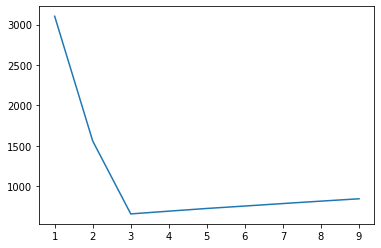

In [0]:
X, y = datagen.generate(n_samples=500,centers=3,cluster_std=0.5)
print("optimal k (BIC): ",model.optimal_k_bic(X))


optimal k (silhouette):  3


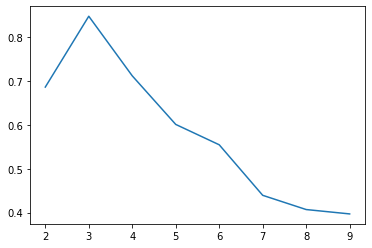

In [0]:
print("optimal k (silhouette): ",model.optimal_k_silhouette(X))


both BIC and silhouette_score method show the correct number of clusters when we test them without noise

Let's try again to add one channel of noise and see the results

optimal k (BIC):  3


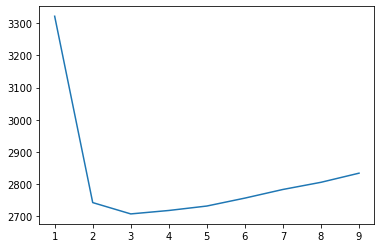

In [32]:
X, y = datagen.generate(n_samples=500,centers=3,cluster_std=0.5)
X= datagen.add_noise_channels(X,1)
print("optimal k (BIC): ",model.optimal_k_bic(X))

optimal k (silhouette):  2


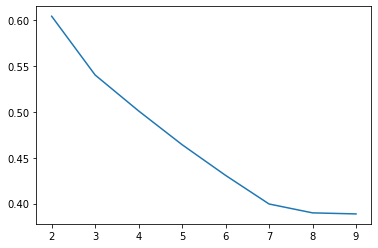

In [33]:
print("optimal k (silhouette): ",model.optimal_k_silhouette(X))


We see that even adding one channel of noise influence the results of the silhouette score so it doesn't report the correct number of cluster,while the BIC method still reports the correct amount

optimal k (BIC):  3


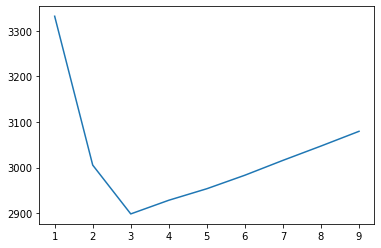

In [37]:
X, y = datagen.generate(n_samples=500,centers=3,cluster_std=0.5)
X= datagen.add_noise_channels(X,15)
print("optimal k (BIC): ",model.optimal_k_bic(X))

even after adding 15 noise channels, the BIC method still reports the correct amount of clusters.

## PCA retaining 3 features

Just change the pca n_components to 3 inside the pipeline

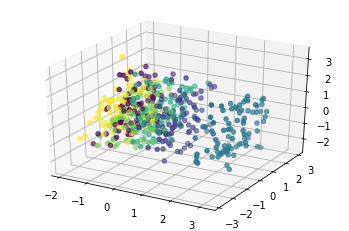

In [48]:
X, y = datagen.generate(n_samples=500,centers=6,cluster_std=0.5)
X= datagen.add_noise_channels(X,5)

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('model',GaussianMixture(n_components=5,covariance_type='full'))
])

model = ClusterFinder(pipe)

X_pca = model.transform(X)
pca_visualization(X_pca,y)



## GMM analysis

3 clusters with 2 channels of noise

optimal k (BIC):  3


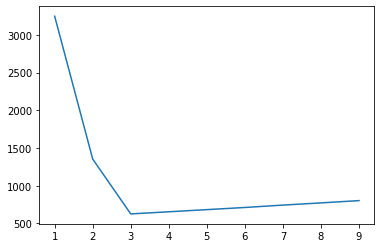

In [56]:
X, y = datagen.generate(n_samples=500,centers=3,cluster_std=0.5)
X= datagen.add_noise_channels(X,2)

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model',GaussianMixture(covariance_type='full'))
])

model = ClusterFinder(pipe)
optimal_k = model.optimal_k_bic(X)
print("optimal k (BIC): ",optimal_k)
pipe['model'].n_components = optimal_k



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: UserWarning: Log scale: values of z <= 0 have been masked


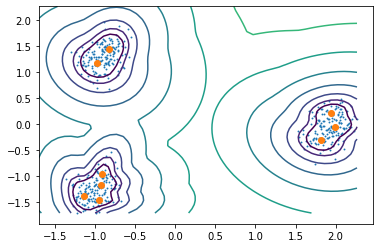

In [57]:
X_pca = model.transform(X)
visualize_gmm(pipe['model'],X_pca)